In [1]:
import pandas as pd

In [42]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [5]:
# предобработка текстов
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel
import pymorphy2  # Морфологический анализатор

In [2]:
import pickle
with open('stopword_ru.pkl', 'rb') as f:
    stopword_ru = pickle.load(f)
print(len(stopword_ru))

776


In [3]:
stopword_ru[:10]

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [4]:
stopword_ru[200:210]

['ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам']

In [6]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [7]:
morph = pymorphy2.MorphAnalyzer()
morph.parse('пробежался')[0].normal_form

'пробежаться'

In [8]:
%%time
from tqdm import tqdm
tqdm.pandas()

# Запускаем очистку текста. Будет долго...
#news['title'] = news['title'].progress_apply(lambda x: clean_text(x))

CPU times: user 1.87 ms, sys: 1.7 ms, total: 3.57 ms
Wall time: 4.86 ms


In [16]:
with open('news.pkl', 'rb') as f:
    news = pickle.load(f)

In [17]:
# сформируем список наших текстов
texts = list(news['title'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [18]:
len(common_dictionary)

135645

In [19]:
common_dictionary[4]

'банк'

In [20]:
common_dictionary.doc2bow(['коллега', 'пошел', 'пить', 'чай'], allow_update=True)

[(993, 1), (6129, 1), (12270, 1), (135645, 1)]

In [21]:
N_topic = 20

In [22]:
from gensim.models import LdaModel
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

CPU times: user 12.3 s, sys: 8.5 ms, total: 12.4 s
Wall time: 12.4 s


In [30]:
# Сохраняем модель на диск
lda.save('model.lda')

In [31]:
# Загружаем обученную модель с диска
lda = LdaModel.load('model.lda')

In [32]:
# Создаем новый корпус документов, которые раньше не видели
other_texts = list(news['title'].iloc[:3])
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(2, 0.13131998),
 (4, 0.10217167),
 (7, 0.13612746),
 (10, 0.12586272),
 (11, 0.2851739),
 (18, 0.20030664)]

In [33]:
x = lda.show_topics(num_topics=N_topic, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Печатаем только слова
for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: городской лекарство музыка горизонт приземлиться комплексный рот
topic_1: грунт эволюция добраться аналог таиланд адмирал святой
topic_2: статья выяснить температура пенсия день общество квартира
topic_3: белоруссия экипаж дыра германия польша европа достигать
topic_4: погибнуть взрыв произойти земля вицепремьер снять треть
topic_5: сша новый тыс эксперт российский рост рынок
topic_6: исследование пациент семья врач школа лечение родитель
topic_7: украина украинский снижение киев всё сторона день
topic_8: километр иран пресссекретарить китай сократиться песок учебный
topic_9: млрд рубль млн фонд составить ставка рак
topic_10: снижение перевод сахар лесной понятие ресторан кит
topic_11: фестиваль конкурс мероприятие сайт вирус участник супруг
topic_12: мужчина женщина остров убийство улица сотрудник фонд
topic_13: двигатель смерть топливо товар белый организм очень
topic_14: бизнесмен определение резерв прекращение особенность констатировать диск
topic_15: россия новый москва r

In [34]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [35]:
get_lda_vector(lda, news['title'].iloc[0])

array([0.        , 0.        , 0.02895337, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.06259681, 0.03239084, 0.014086  , 0.        ,
       0.85444069, 0.        , 0.        , 0.        , 0.        ])

In [36]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

CPU times: user 9.56 s, sys: 3.46 ms, total: 9.56 s
Wall time: 9.57 s


,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.0,0.0,0.028968,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.062619,0.032088,0.014083,0.0,0.854710,0.0,0.000000,0.000000,0.000000
1,4896,0.0,0.0,0.000000,0.0,0.346986,0.0,0.0,0.000000,0.0,...,0.199609,0.119880,0.000000,0.000000,0.0,0.312450,0.0,0.000000,0.000000,0.000000
2,4897,0.0,0.0,0.131507,0.0,0.102148,0.0,0.0,0.136084,0.0,...,0.125861,0.285120,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.200243,0.000000
3,4898,0.0,0.0,0.610267,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.111728,0.000000,0.000000,0.0,0.061036,0.0,0.175947,0.031243,0.000000
4,4899,0.0,0.0,0.057209,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.082639,0.000000,0.000000,0.0,0.000000,0.0,0.115696,0.000000,0.720868


In [37]:
topic_matrix.head()

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.0,0.0,0.028968,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.062619,0.032088,0.014083,0.0,0.854710,0.0,0.000000,0.000000,0.000000
1,4896,0.0,0.0,0.000000,0.0,0.346986,0.0,0.0,0.000000,0.0,...,0.199609,0.119880,0.000000,0.000000,0.0,0.312450,0.0,0.000000,0.000000,0.000000
2,4897,0.0,0.0,0.131507,0.0,0.102148,0.0,0.0,0.136084,0.0,...,0.125861,0.285120,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.200243,0.000000
3,4898,0.0,0.0,0.610267,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.111728,0.000000,0.000000,0.0,0.061036,0.0,0.175947,0.031243,0.000000
4,4899,0.0,0.0,0.057209,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.082639,0.000000,0.000000,0.0,0.000000,0.0,0.115696,0.000000,0.720868


In [38]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [39]:
doc_dict[293672]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.34759244, 0.        , 0.        , 0.        , 0.07647243,
       0.        , 0.05808503, 0.        , 0.        , 0.        ,
       0.4956173 , 0.        , 0.        , 0.        , 0.        ])

In [40]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.mean(user_vector, 0)  # можно не среднее
    return user_vector

In [43]:
user_articles_list = users['articles'].iloc[33]

get_user_embedding(user_articles_list, doc_dict)

array([0.        , 0.        , 0.01341466, 0.        , 0.        ,
       0.20298164, 0.04635561, 0.07636671, 0.03376292, 0.00453349,
       0.        , 0.00716954, 0.05755658, 0.02543748, 0.        ,
       0.12567184, 0.        , 0.3823416 , 0.        , 0.00651212])

In [44]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

CPU times: user 179 ms, sys: 3.95 ms, total: 183 ms
Wall time: 183 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.000000,0.0,0.004933,0.003619,0.010931,0.327033,0.020835,0.169838,0.013807,...,0.004435,0.049208,0.035510,0.043163,0.000000,0.192245,0.0,0.072112,0.005272,0.013527
1,u108690,0.000000,0.0,0.012888,0.000000,0.000000,0.260150,0.024156,0.165209,0.000000,...,0.002398,0.025838,0.025997,0.047119,0.001985,0.195477,0.0,0.194847,0.007127,0.006479
2,u108339,0.002824,0.0,0.046271,0.000000,0.029614,0.313128,0.035836,0.078401,0.002221,...,0.000000,0.016177,0.049761,0.006099,0.000000,0.157537,0.0,0.203047,0.023875,0.004637


In [45]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [46]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.000000,0.0,0.004933,0.003619,0.010931,0.327033,0.020835,0.169838,0.013807,...,0.049208,0.035510,0.043163,0.000000,0.192245,0.0,0.072112,0.005272,0.013527,0
1,u108690,0.000000,0.0,0.012888,0.000000,0.000000,0.260150,0.024156,0.165209,0.000000,...,0.025838,0.025997,0.047119,0.001985,0.195477,0.0,0.194847,0.007127,0.006479,1
2,u108339,0.002824,0.0,0.046271,0.000000,0.029614,0.313128,0.035836,0.078401,0.002221,...,0.016177,0.049761,0.006099,0.000000,0.157537,0.0,0.203047,0.023875,0.004637,1


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [48]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [49]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [50]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.08048876, 0.13418255, 0.33970994, 0.22251129, 0.10885281,
       0.21325002, 0.09821525, 0.04802749, 0.07405681, 0.04875217])

In [51]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)

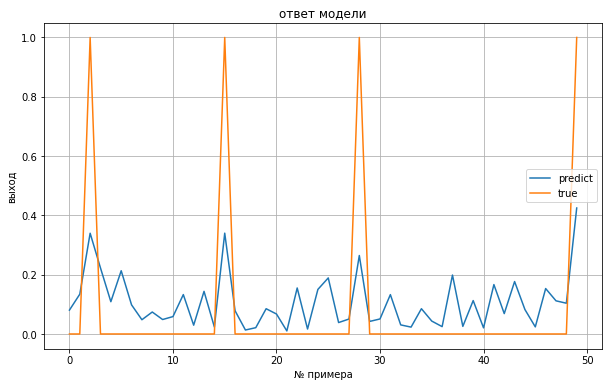

In [52]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [53]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.25322480972290773, F-Score=0.664, Precision=0.615, Recall=0.722


In [54]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1644  111]
 [  69  176]]


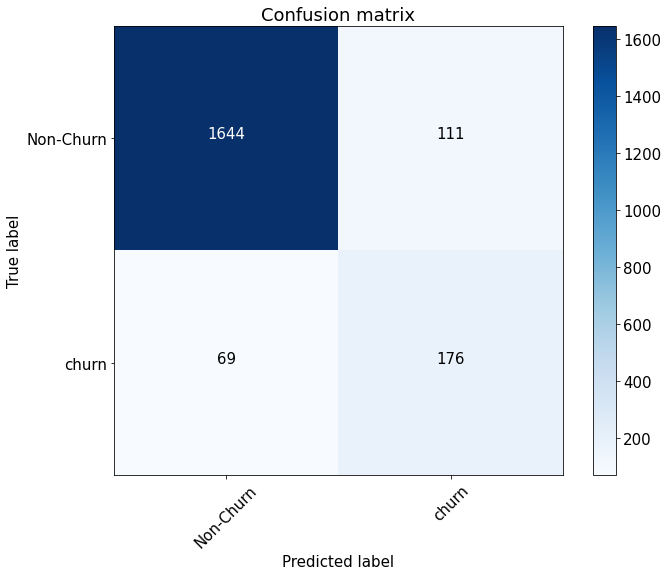

In [55]:
import itertools
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [56]:
roc_auc_score(y_test, preds)

0.9362265247979533